In [1]:
import numpy as np

import pandas as pd

import sklearn

import sklearn.preprocessing

from keras.models import Sequential

from keras.layers import Dense , BatchNormalization , Dropout , Activation

from keras.layers import LSTM , GRU

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from keras.optimizers import Adam, SGD, RMSprop

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from keras import losses

%matplotlib inline

In [2]:
df = pd.read_csv('prices-split-adjusted.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df.index = df.date

df.drop('date', axis = 1, inplace = True)

df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
df = df[df.symbol == 'AAPL']

In [5]:
df.drop('symbol', axis = 1, inplace = True)

In [6]:
df_target = df[['close']]

In [7]:
col_list = df.columns.tolist()

In [8]:
col_list

['open', 'close', 'low', 'high', 'volume']

In [12]:
df_feature = df

In [13]:
df_feature.drop('close', axis = 1, inplace = True)
df_feature.head()

,open,low,high,volume
date,,,,
2010-01-04,30.490000,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.107143,30.747143,138040000.0
2010-01-07,30.250000,29.864286,30.285715,119282800.0
2010-01-08,30.042856,29.865715,30.285715,111902700.0


In [14]:
df_feature['close'] = df_target['close']

In [9]:
df_target = pd.DataFrame(df_target, columns = ['close'])

In [20]:
df_feature.head()

,open,low,high,volume,close
date,,,,,
2010-01-04,30.490000,30.340000,30.642857,123432400.0,30.572857
2010-01-05,30.657143,30.464285,30.798571,150476200.0,30.625713
2010-01-06,30.625713,30.107143,30.747143,138040000.0,30.138571
2010-01-07,30.250000,29.864286,30.285715,119282800.0,30.082857
2010-01-08,30.042856,29.865715,30.285715,111902700.0,30.282858


In [19]:
df_target.head()

,close
date,
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858


In [31]:
df_feature.drop('close', axis = 1, inplace = True)

In [15]:
df_feature['close'] = df_target['close']

In [21]:
MMS_F = MinMaxScaler()
MMS_T = MinMaxScaler()

df_feature = pd.DataFrame(MMS_F.fit_transform(df_feature.values))
df_target = pd.DataFrame(MMS_T.fit_transform(df_target.values))

In [23]:
df_feature.columns = ['open', 'low', 'high', 'volume', 'close']

In [24]:
df_target.columns = ['close']

In [26]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i : i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
        
    return np.array(feature_list), np.array(label_list)

In [27]:
x_train = df_feature[:1500]
x_test = df_feature[1500:]

y_train = df_target[:1500]
y_test = df_target[1500:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1500, 5), (262, 5), (1500, 1), (262, 1))

In [28]:
x_train, y_train = make_dataset(x_train, y_train, 24)
x_test, y_test = make_dataset(x_test, y_test, 24)

In [29]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1476, 24, 5), (1476, 1), (238, 24, 5), (238, 1))

In [37]:
def build_model():
    
    model = Sequential()
    model.add(LSTM(256, input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer = "uniform", activation = 'linear'))
    
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               268288    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss = 'mse', optimizer = Adam(), metrics = ['accuracy'])

In [39]:
history = model.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Epoch 1/50
11/11 [==============================] - 5s 210ms/step - loss: 0.0968 - accuracy: 6.7605e-04 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 2/50
11/11 [==============================] - 2s 175ms/step - loss: 0.0061 - accuracy: 0.0011 - val_loss: 0.0150 - val_accuracy: 0.0000e+00
Epoch 3/50
11/11 [==============================] - 2s 184ms/step - loss: 0.0035 - accuracy: 6.7605e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 4/50
11/11 [==============================] - 3s 252ms/step - loss: 0.0014 - accuracy: 0.0014 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 5/50
11/11 [==============================] - 3s 271ms/step - loss: 0.0011 - accuracy: 4.3733e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/50
11/11 [==============================] - 3s 261ms/step - loss: 0.0011 - accuracy: 2.6294e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 7/50
11/11 [==============================] - 3s 237ms/step - loss: 9.7019e-04 - accuracy: 6.7605e-04 

In [41]:
pred = model.predict(x_test)
pred[:10]

array([[0.65201265],
       [0.6587533 ],
       [0.6641869 ],
       [0.65943277],
       [0.6532185 ],
       [0.64812785],
       [0.64493036],
       [0.6404696 ],
       [0.63709503],
       [0.6360821 ]], dtype=float32)

In [42]:
y_test = MMS_T.inverse_transform(y_test)
y_test[:10]

array([[99.440002],
       [99.989998],
       [93.419998],
       [94.089996],
       [97.339996],
       [96.43    ],
       [94.480003],
       [96.349998],
       [96.599998],
       [94.019997]])

In [43]:
y_test.shape

(238, 1)

In [44]:
pred = MMS_T.inverse_transform(pred)
pred[:10]

array([[96.26496 ],
       [96.97653 ],
       [97.55013 ],
       [97.04826 ],
       [96.39226 ],
       [95.854866],
       [95.51733 ],
       [95.04643 ],
       [94.69019 ],
       [94.58327 ]], dtype=float32)

In [46]:
import matplotlib.pyplot as plt

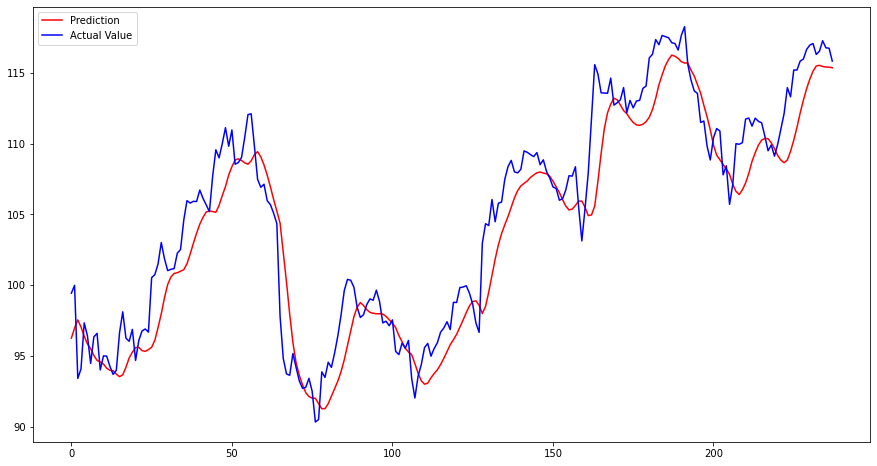

In [50]:
ax, fig = plt.subplots(figsize = (15, 8))

plt.plot(pred, color = 'red', label = 'Prediction')
plt.plot(y_test, color = 'blue', label = 'Actual Value')
plt.legend()

plt.savefig('Keras_LSTM_1.jpg')